In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox, chi2_contingency
from scipy.special import inv_boxcox

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import pickle

from common.utils import *

pd.options.display.max_rows = 200

In [3]:
train_data = pd.read_csv('../data/Crop_Data__train.csv')

In [4]:
df = train_data.copy()

In [5]:
# Track columns which need to be dropped
cols_to_drop = []

# Yield = Boxcox(Yield)

In [6]:
df, lmda = convert_to_yield(df, to_boxcox=True)

In [7]:
df.head()

,State,District,Lat,Long,GW_depth_Min,GW_depth_Max,Wells_depth_0_to_2,Wells_depth_2_to_5,Wells_depth_5_to_10,Wells_depth_10_to_20,...,Temp_Max,Temp_Min,Dew_Frost_Point,Wind_Speed,Year,Season,Crop,Area,Production,Yield
0,ODISHA,JAJAPUR,20.86859,86.11638,0.97,9.07,3,18,5,0.0,...,36.082,24.792,21.515,2.808,2015,Summer,Moong(Green Gram),10466.0,2407.2,0.190035
1,ODISHA,SUNDARGARH,22.05730,83.92644,0.15,13.55,6,31,26,5.0,...,28.306,13.554,8.416,1.606,1999,Rabi,Niger seed,6770.0,2170.0,0.247986
2,BIHAR,SITAMARHI,26.57491,85.58580,2.37,10.00,0,11,4,0.0,...,27.408,13.560,5.488,1.356,2004,Rabi,Wheat,49806.0,80475.0,0.659940
3,ANDHRA PRADESH,VIZIANAGARAM,18.39887,83.25060,2.11,12.15,0,13,31,3.0,...,29.188,17.958,15.334,1.738,2013,Rabi,Gram,525.0,1012.0,0.707905
4,KARNATAKA,UTTARA KANNADA,14.67264,74.47292,1.99,17.45,1,9,37,22.0,...,29.228,23.070,20.968,1.949,2000,Whole Year,Black pepper,135.0,330.0,0.769615


In [8]:
print(f"Boxcox lambda - {lmda}")

Boxcox lambda - -0.8390130527574972


## Drop Production and Area

In [9]:
df = df.drop(['Production', 'Area'], axis=1)

# Categorical Columns

## Lat and Long

We must consider Lat and Long as categorical features to avoid any bias in prediction value. This is because numerical values of latitide and longitude do not quantify the production of crop but only provide information of geographical location.

In [10]:
df[['Lat', 'Long']].nunique()

Lat     459
Long    459
dtype: int64

**Pipeline Action**

Based on cluster analysis and EDA we can seggregate Lat and Long values into six regions.

In [11]:
with open('../Analysis_and_Data_Processing/latlong_custerer_6.pkl', 'rb') as f:
    lat_long_clusterer = pickle.load(f)

In [12]:
df = identify_geo_region(df, lat_long_clusterer)

In [13]:
df['Geo_Region'].value_counts().sort_index()

R0    27655
R1    33635
R2    14811
R3    36484
R4    20660
R5    31305
Name: Geo_Region, dtype: int64

In [14]:
df = df.drop(['Lat', 'Long'], axis=1)

In [15]:
cols_to_drop.append('Lat')
cols_to_drop.append('Long')

## State and District

In [16]:
df['State'].nunique()

30

In [17]:
df['District'].nunique()

516

**Pipeline Action**

We can drop State and District columns as they are well represented by Geo_Region clusters.

Also being categorical input with many unique values, State and District would increase the feature set a lot.

In [18]:
df = df.drop(['State', 'District'], axis=1)

cols_to_drop.append('State')
cols_to_drop.append('District')

## Geo_Region

In [19]:
df['Geo_Region'].value_counts()

R3    36484
R1    33635
R5    31305
R0    27655
R4    20660
R2    14811
Name: Geo_Region, dtype: int64

<AxesSubplot:xlabel='Geo_Region', ylabel='Yield'>

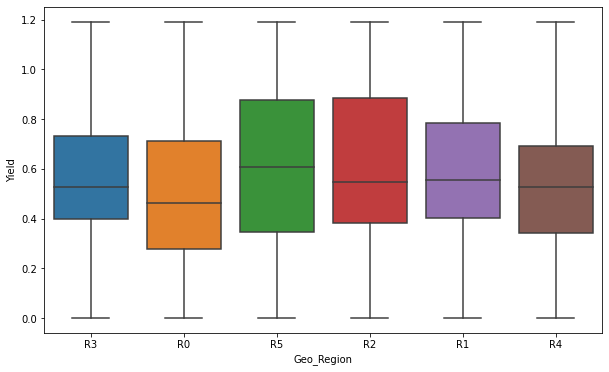

In [20]:
plt.figure(figsize=(10,6))
sns.boxplot(y='Yield', x='Geo_Region', data=df)

In [21]:
# ANOVA test with Yield
anova_result = smf.ols(formula='Yield ~ C(Geo_Region)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     586.2
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:15:20   Log-Likelihood:                -27225.
No. Observations:              164550   AIC:                         5.446e+04
Df Residuals:                  164544   BIC:                         5.452e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5187      0.002    302.112      0.000       0.515       0.522
C(Geo_Region)[T.R1]     0.0780      0.002     33.666      0.000       0.073       0.083
C(Geo_Region)[T.R2]     0.1088      0.003     37.440      0.000       0.103       0.115
C(Geo_Region)[T.R3]     0.0627      0.002     27.529      0.000       0.058       0.067
C(Geo_Region)[T.R4]     0.0183      0.003      6.979      0.000       0.013       0.023
C(Geo_Region)[T.R5]     0.1028      0.002     43.624      0.000       0.098       0.107
==============================================================================
Omnibus:                    10767.544   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6606.385
Skew:                           0.360   Prob(JB):                         0.00
Kurtosis:                       2.333   Cond. No.                         6.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Season

In [22]:
df['Season'].value_counts()

Kharif        63272
Rabi          44196
Whole Year    38754
Summer        10850
Winter         4113
Autumn         3365
Name: Season, dtype: int64

<AxesSubplot:xlabel='Season', ylabel='Yield'>

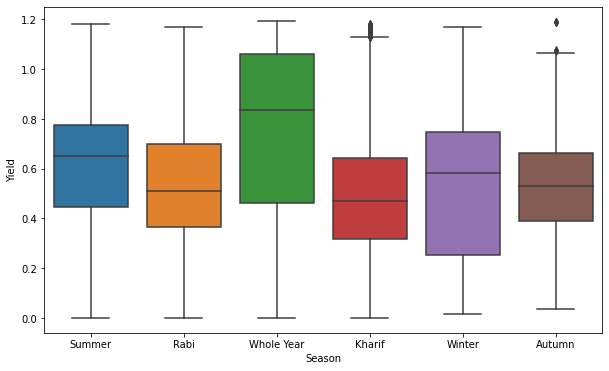

In [23]:
plt.figure(figsize=(10,6))
sns.boxplot(y='Yield', x='Season', data=df)

In [24]:
# ANOVA test with Yield
anova_result = smf.ols(formula='Yield ~ C(Season)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     4678.
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:15:21   Log-Likelihood:                -17741.
No. Observations:              164550   AIC:                         3.549e+04
Df Residuals:                  164544   BIC:                         3.555e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.5184      0.005    111.575      0.000       0.509       0.528
C(Season)[T.Kharif]        -0.0201      0.005     -4.210      0.000      -0.029      -0.011
C(Season)[T.Rabi]           0.0224      0.005      4.650      0.000       0.013       0.032
C(Season)[T.Summer]         0.1066      0.005     20.053      0.000       0.096       0.117
C(Season)[T.Whole Year]     0.2355      0.005     48.627      0.000       0.226       0.245
C(Season)[T.Winter]         0.0391      0.006      6.234      0.000       0.027       0.051
==============================================================================
Omnibus:                     1336.451   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              898.587
Skew:                           0.032   Prob(JB):                    7.49e-196
Kurtosis:                       2.644   Cond. No.                         19.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Crop

In [25]:
df['Crop'].nunique()

81

In [26]:
# ANOVA test with Yield
anova_result = smf.ols(formula='Yield ~ C(Crop)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     4753.
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:15:24   Log-Likelihood:                 69846.
No. Observations:              164550   AIC:                        -1.395e+05
Df Residuals:                  164469   BIC:                        -1.387e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.5971      0.041     14.607      0.000       0.517       0.677
C(Crop)[T.Arecanut]                     -0.0009      0.041     -0.023      0.982      -0.082       0.080
C(Crop)[T.Arhar/Tur]                    -0.1609      0.041     -3.931      0.000      -0.241      -0.081
C(Crop)[T.Atcanut (Raw)]                 0.3534      0.058      6.114      0.000       0.240       0.467
C(Crop)[T.Bajra]                        -0.0689      0.041     -1.683      0.092      -0.149       0.011
C(Crop)[T.Banana]                        0.4804      0.041     11.713      0.000       0.400       0.561
C(Crop)[T.Barley]                        0.0668      0.041      1.630      0.103      -0.014       0.147
C(Crop)[T.Beans & Mutter(Vegetable)]    -0.1614      0.044     -3.704      0.000      -0.247      -0.076
C(Crop)[T.Bhindi]                       -0.1481      0.043     -3.473      0.001      -0.232      -0.065
C(Crop)[T.Black pepper]                 -0.1416      0.041     -3.426      0.001      -0.223      -0.061
C(Crop)[T.Blackgram]                    -0.1766      0.047     -3.772      0.000      -0.268      -0.085
C(Crop)[T.Brinjal]                       0.0949      0.042      2.262      0.024       0.013       0.177
C(Crop)[T.Cabbage]                      -0.1199      0.043     -2.792      0.005      -0.204      -0.036
C(Crop)[T.Cardamom]                     -0.5143      0.042    -12.245      0.000      -0.597      -0.432
C(Crop)[T.Cashewnut]                    -0.2856      0.041     -6.923      0.000      -0.366      -0.205
C(Crop)[T.Cashewnut Processed]          -0.5054      0.056     -9.013      0.000      -0.615      -0.396
C(Crop)[T.Cashewnut Raw]                -0.2608      0.051     -5.149      0.000      -0.360      -0.162
C(Crop)[T.Castor seed]                  -0.2210      0.041     -5.388      0.000      -0.301      -0.141
C(Crop)[T.Citrus Fruit]                 -0.1239      0.042     -2.933      0.003      -0.207      -0.041
C(Crop)[T.Coconut]                       0.4384      0.041     10.669      0.000       0.358       0.519
C(Crop)[T.Coffee]                       -0.1746      0.082     -2.136      0.033      -0.335      -0.014
C(Crop)[T.Coriander]                    -0.2759      0.041     -6.729      0.000      -0.356      -0.196
C(Crop)[T.Cotton(lint)]                 -0.0220      0.041     -0.537      0.591      -0.102       0.058
C(Crop)[T.Cowpea(Lobia)]                -0.2893      0.042     -6.946      0.000      -0.371      -0.208
C(Crop)[T.Drum Stick]                   -0.3415      0.044     -7.734      0.000      -0.428      -0.255
C(Crop)[T.Dry chillies]                 -0.0623      0.041     -1.523      0.128      -0.143       0.018
C(Crop)[T.Dry ginger]                 

In [27]:
# Chi2 test
chi2_contingency(pd.crosstab(df['Crop'], df['Season']))

(229374.57022164742,
 0.0,
 400,
 array([[3.06745670e-01, 5.76773017e+00, 4.02880583e+00, 9.89061076e-01,
         3.53272562e+00, 3.74931632e-01],
        [2.24742328e+01, 4.22582364e+02, 2.95177174e+02, 7.24652081e+01,
         2.58831030e+02, 2.74699909e+01],
        [1.10960134e+02, 2.08638026e+03, 1.45735336e+03, 3.57776360e+02,
         1.27790461e+03, 1.35625269e+02],
        [3.06745670e-01, 5.76773017e+00, 4.02880583e+00, 9.89061076e-01,
         3.53272562e+00, 3.74931632e-01],
        [8.23305378e+01, 1.54805878e+03, 1.08133149e+03, 2.65463993e+02,
         9.48183555e+02, 1.00631650e+02],
        [4.59709511e+01, 8.64390495e+02, 6.03783701e+02, 1.48227287e+02,
         5.29437812e+02, 5.61897539e+01],
        [5.94882103e+01, 1.11855514e+03, 7.81319745e+02, 1.91811911e+02,
         6.85113254e+02, 7.27117411e+01],
        [2.24946825e+00, 4.22966879e+01, 2.95445761e+01, 7.25311455e+00,
         2.59066545e+01, 2.74949863e+00],
        [3.47645093e+00, 6.53676086e+01, 4.5659

Ideally crops are very much dependent on season. p-value of chi2 test validates this.

**X - Pipeline Action (Discarded due to loss of information in clusters of crop)**

As per custer analysis and EDA, we can reduce the feature set by clustering both Season and Crop columns as Crop_Type.

In [28]:
with open('../Analysis_and_Data_Processing/crop_season_clusterer_6.pkl', 'rb') as f:
    crop_season_clusterer = pickle.load(f)

In [29]:
df = identify_crop_types(df, crop_season_clusterer)

In [30]:
df['Crop_Type'].value_counts().sort_index()

C0     4113
C1    38754
C2    63272
C3     3365
C4    44196
C5    10850
Name: Crop_Type, dtype: int64

In [31]:
# ANOVA test with Yield
anova_result = smf.ols(formula='Yield ~ C(Crop_Type)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     4678.
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:15:26   Log-Likelihood:                -17741.
No. Observations:              164550   AIC:                         3.549e+04
Df Residuals:                  164544   BIC:                         3.555e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.5575      0.004    132.647      0.000       0.549       0.566
C(Crop_Type)[T.C1]     0.1965      0.004     44.453      0.000       0.188       0.205
C(Crop_Type)[T.C2]    -0.0591      0.004    -13.634      0.000      -0.068      -0.051
C(Crop_Type)[T.C3]    -0.0391      0.006     -6.234      0.000      -0.051      -0.027
C(Crop_Type)[T.C4]    -0.0166      0.004     -3.788      0.000      -0.025      -0.008
C(Crop_Type)[T.C5]     0.0676      0.005     13.695      0.000       0.058       0.077
==============================================================================
Omnibus:                     1336.451   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              898.587
Skew:                           0.032   Prob(JB):                    7.49e-196
Kurtosis:                       2.644   Cond. No.                         18.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Year

**Pipeline Action**

We must drop Year column to avoid the prediction dependency on Year.

In [32]:
df = df.drop('Year', axis=1)

# Numerical Columns

## Normalize numerical features

In [33]:
for col in ['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Dew_Frost_Point', 'Wind_Speed']:
    df[col] = preprocessing.minmax_scale(df[col], feature_range=(1,2))

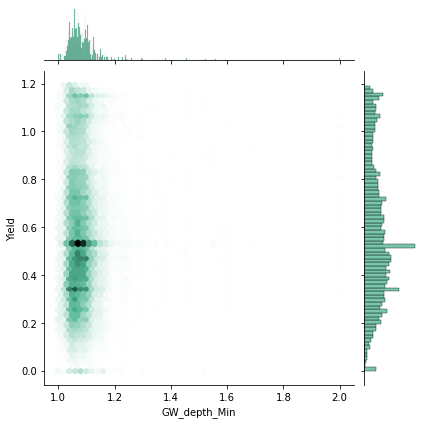

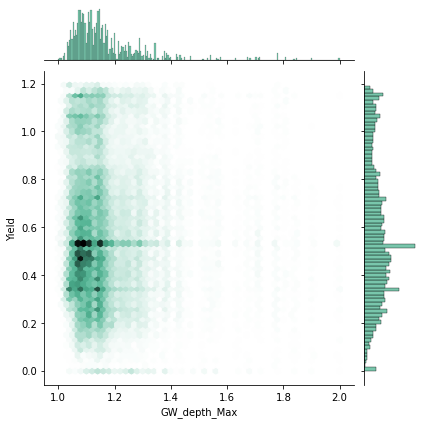

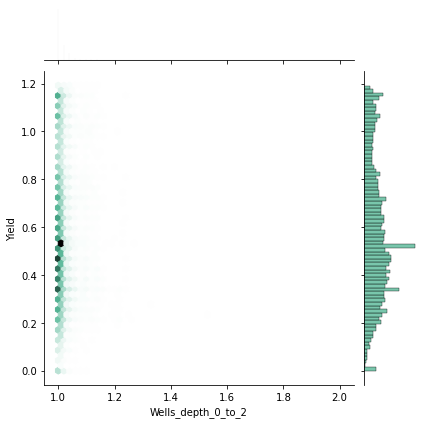

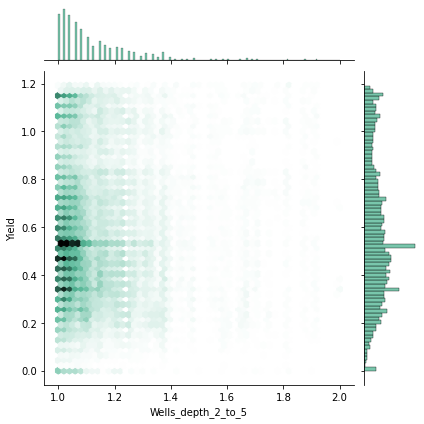

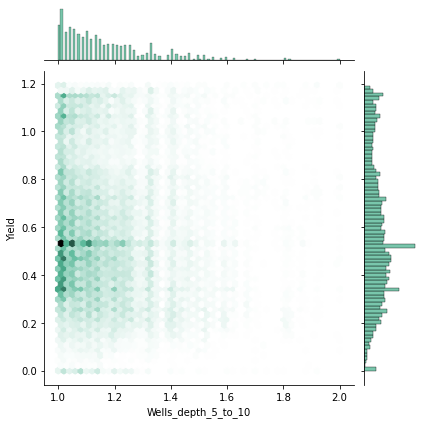

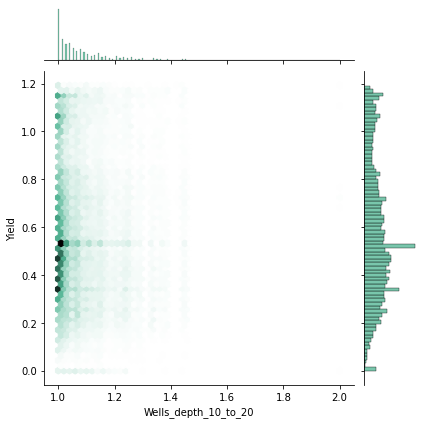

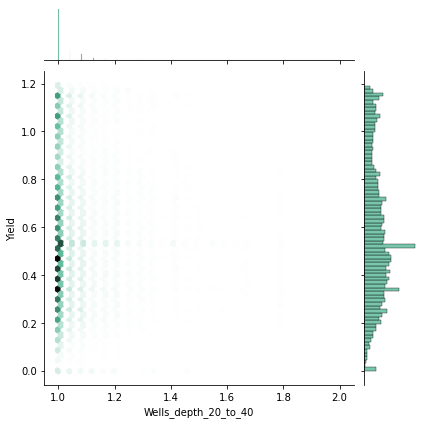

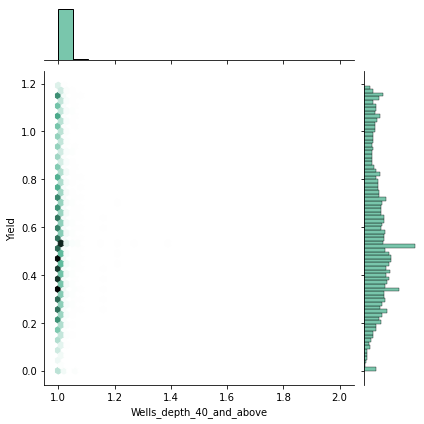

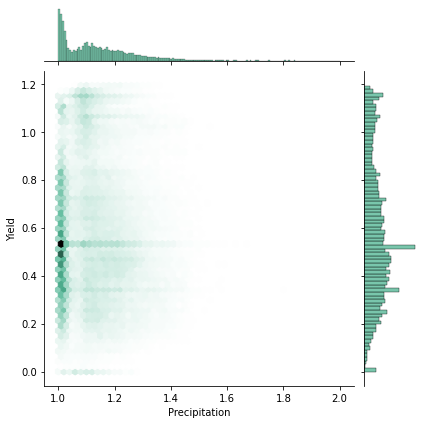

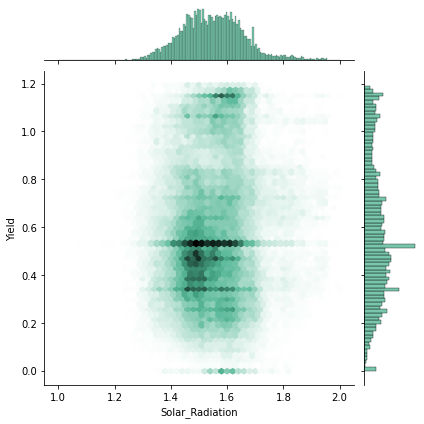

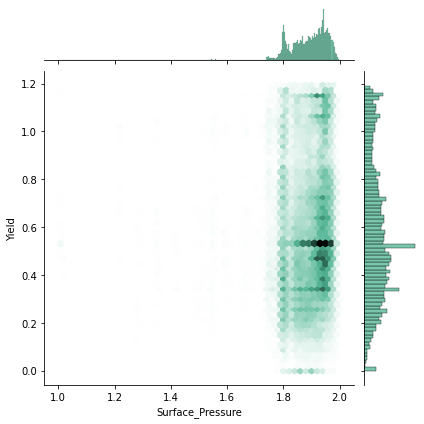

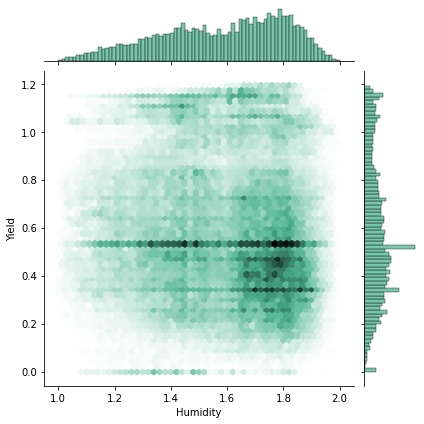

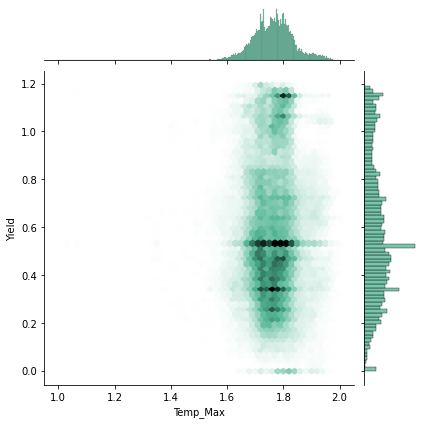

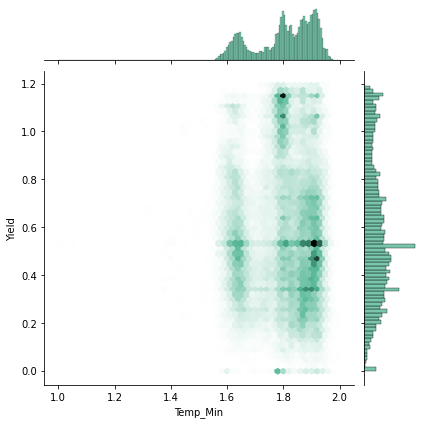

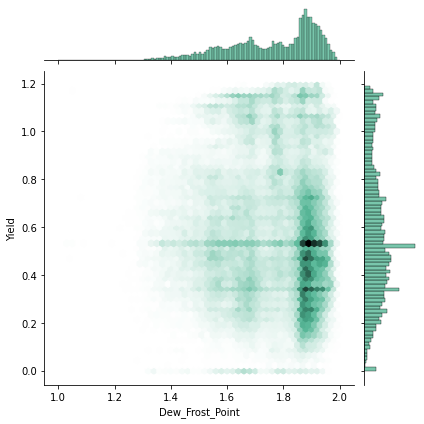

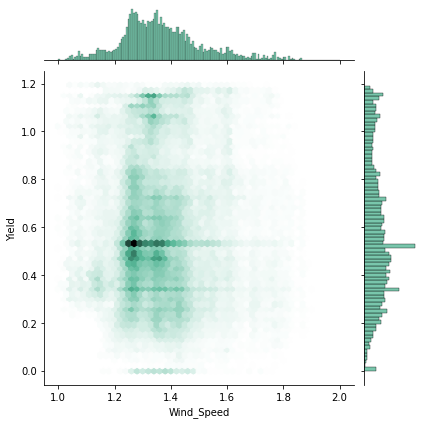

In [34]:
# Yield vs columns
for col in ['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Dew_Frost_Point', 'Wind_Speed']:
    sns.jointplot(x=col, y='Yield', data=df, kind="hex", color="#4CB391")
    plt.xlabel(col)
    plt.ylabel('Yield = BoxCox(Yield)')
    plt.show()



boxcox-GW_depth_Min vs. Yield = BoxCox(Yield)


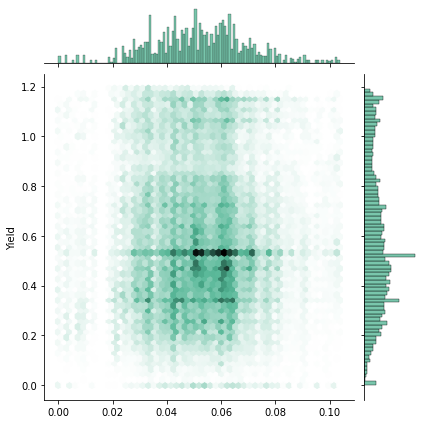



boxcox-GW_depth_Max vs. Yield = BoxCox(Yield)


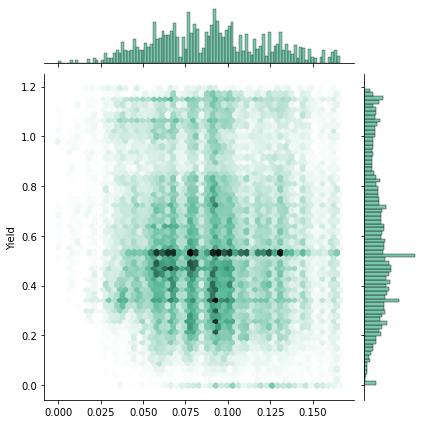



boxcox-Wells_depth_0_to_2 vs. Yield = BoxCox(Yield)


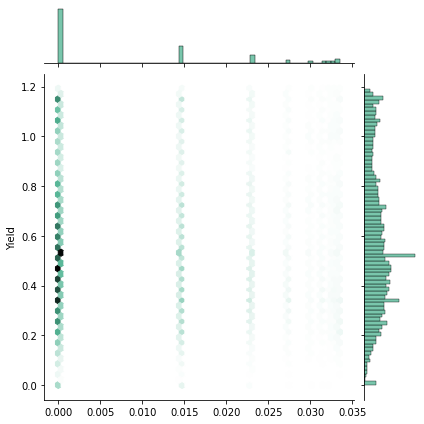



boxcox-Wells_depth_2_to_5 vs. Yield = BoxCox(Yield)


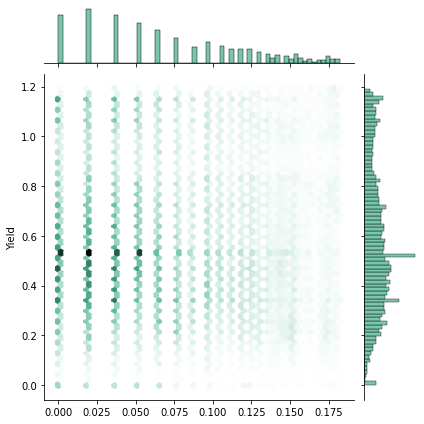



boxcox-Wells_depth_5_to_10 vs. Yield = BoxCox(Yield)


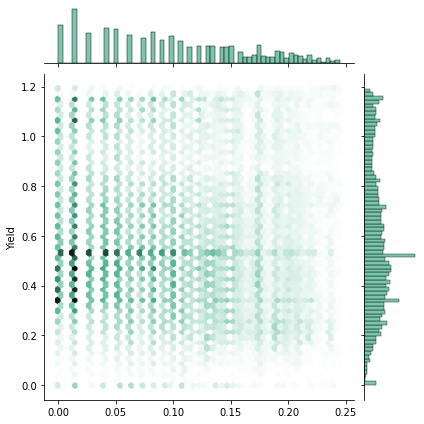



boxcox-Wells_depth_10_to_20 vs. Yield = BoxCox(Yield)


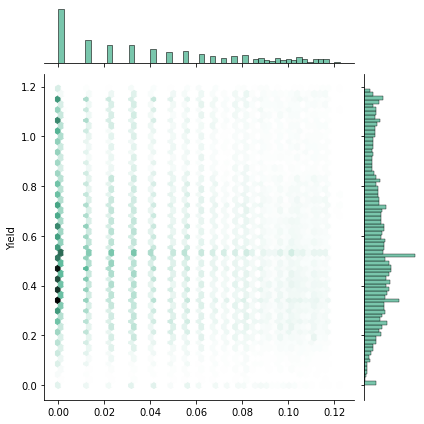



boxcox-Wells_depth_20_to_40 vs. Yield = BoxCox(Yield)


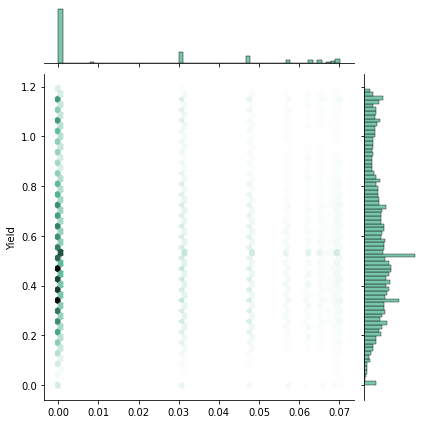



boxcox-Wells_depth_40_and_above vs. Yield = BoxCox(Yield)


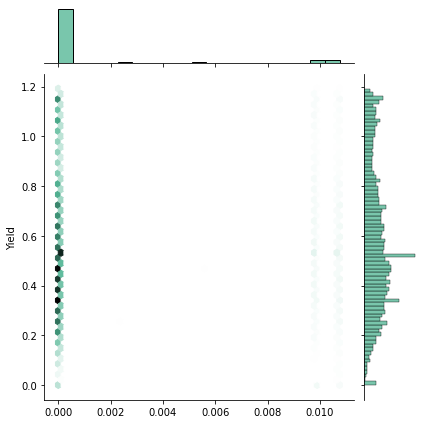



boxcox-Precipitation vs. Yield = BoxCox(Yield)


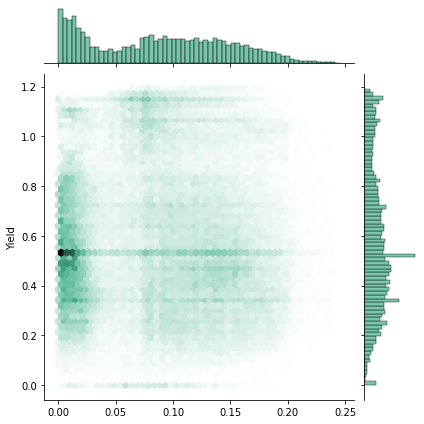



boxcox-Solar_Radiation vs. Yield = BoxCox(Yield)


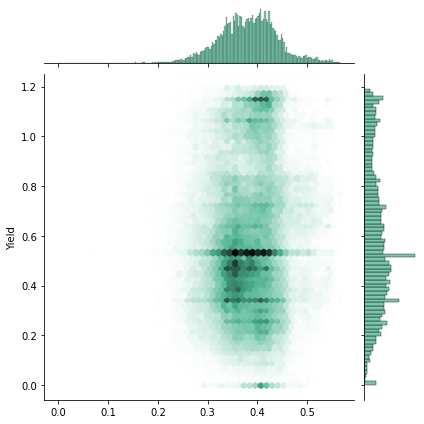



boxcox-Surface_Pressure vs. Yield = BoxCox(Yield)


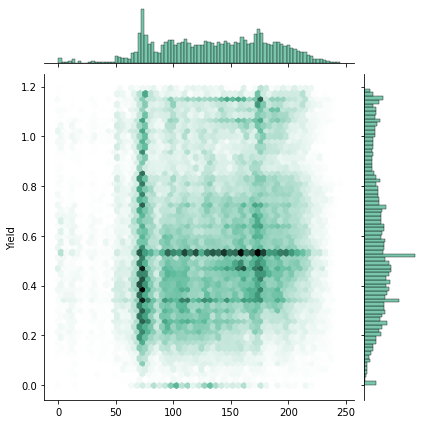



boxcox-Humidity vs. Yield = BoxCox(Yield)


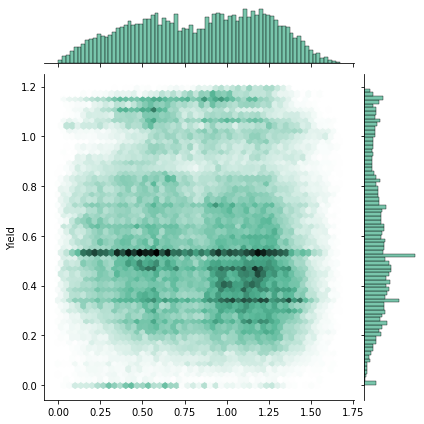



boxcox-Temp_Max vs. Yield = BoxCox(Yield)


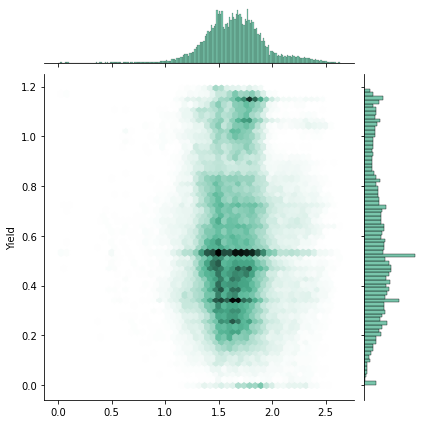



boxcox-Temp_Min vs. Yield = BoxCox(Yield)


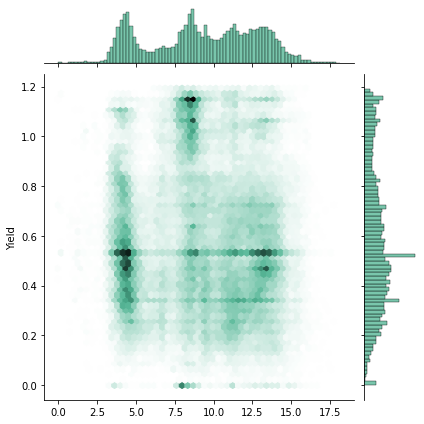



boxcox-Dew_Frost_Point vs. Yield = BoxCox(Yield)


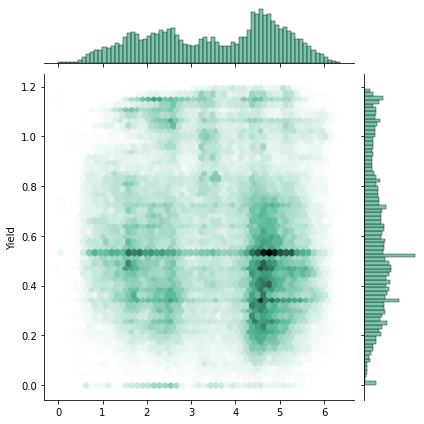



boxcox-Wind_Speed vs. Yield = BoxCox(Yield)


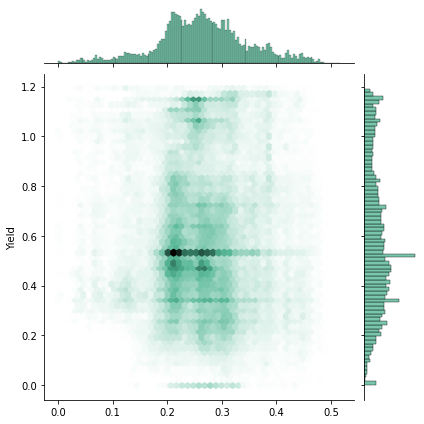

In [35]:
# Yield vs boxcox-columns
for col in ['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Dew_Frost_Point', 'Wind_Speed']:
    print(f'\n\nboxcox-{col} vs. Yield = BoxCox(Yield)')
    sns.jointplot(x=boxcox(df[col])[0], y=df['Yield'], kind="hex", color="#4CB391")
    plt.show()

## Correlation

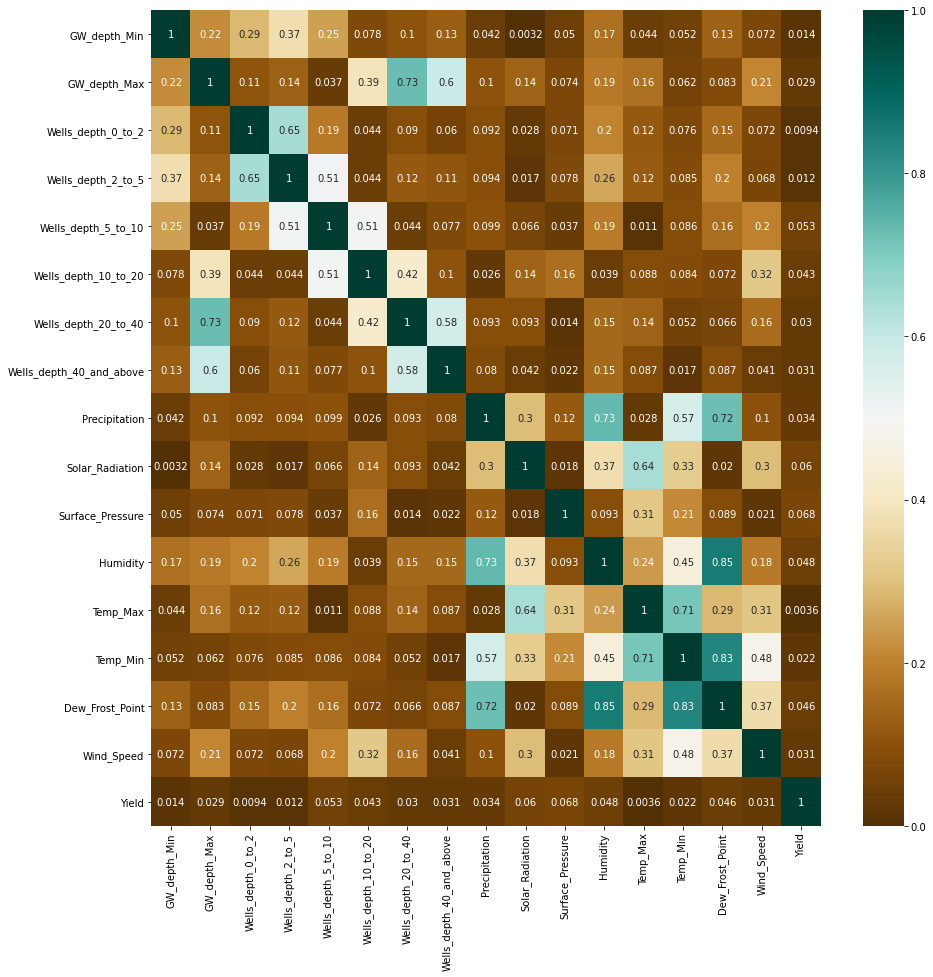

In [36]:
df_for_corr = df.select_dtypes(exclude='object').copy()

plt.figure(figsize=(15,15))
sns.heatmap(df_for_corr.corr().abs(), annot=True, vmin=0, vmax=1, cmap=plt.cm.BrBG)
plt.show()

**Note**

Taking correlation cut-off as 80.

We find following as highly correlated features:
1. Humidity vs. Dew_Frost_Point
2. Temp_Min vs Dew_Frost_Point

**Pipeline Action**

Drop column Dew_Frost_Point due to high correlation (above 80)

In [37]:
# Drop Dew_Frost_Point due to high correlation
df = df.drop('Dew_Frost_Point', axis=1)

print(df.shape)
print(df.columns)

(164550, 20)
Index(['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Wind_Speed', 'Season', 'Crop', 'Yield', 'Geo_Region',
       'Crop_Type'],
      dtype='object')


## ANOVA test for Crop, Season and Geo_Region

In [38]:
model = smf.ols('Yield ~ Crop', data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print('\n\n')

model = smf.ols('Yield ~ Season', data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print('\n\n')

model = smf.ols('Yield ~ Geo_Region', data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print('\n\n')

model = smf.ols('Yield ~ Crop + Season', data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print('\n\n')

model = smf.ols('Yield ~ Crop + Season + Geo_Region', data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print('\n\n')

               sum_sq        df            F  PR(>F)
Crop      9529.827072      80.0  4752.734747     0.0
Residual  4122.261214  164469.0          NaN     NaN



                sum_sq        df            F  PR(>F)
Season     1699.273909       5.0  4678.485204     0.0
Residual  11952.814377  164544.0          NaN     NaN



                  sum_sq        df           F  PR(>F)
Geo_Region    238.908488       5.0  586.154198     0.0
Residual    13413.179798  164544.0         NaN     NaN



               sum_sq        df            F  PR(>F)
Crop      7966.800944      80.0  4108.904713     0.0
Season     136.247781       5.0  1124.324109     0.0
Residual  3986.013433  164464.0          NaN     NaN



                 sum_sq        df            F  PR(>F)
Crop        7873.023156      80.0  4141.323092     0.0
Season       127.107891       5.0  1069.769181     0.0
Geo_Region    77.873792       5.0   655.403707     0.0
Residual    3908.139641  164459.0          NaN     NaN





Above results of ANOVA test shows that Crop, Season and Geo_Region have significant impact on Yield.

# Feature Importance

## Analysis using OLS

In [39]:
def ols_summary(cols, Yield, data):
    formula_str = f"{Yield} ~ "
    for col in cols:
        formula_str += f" + {col}"
    return smf.ols(formula=formula_str, data=data).fit().summary()

In [40]:
ols_summary(['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Wind_Speed', 'C(Crop)', 'C(Season)', 'C(Geo_Region)'], 'Yield', df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     4113.
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:17:04   Log-Likelihood:                 77308.
No. Observations:              164550   AIC:                        -1.544e+05
Df Residuals:                  164444   BIC:                        -1.533e+05
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.5518      0.048     11.430      0.000       0.457       0.646
C(Crop)[T.Arecanut]                     -0.0270      0.039     -0.686      0.492      -0.104       0.050
C(Crop)[T.Arhar/Tur]                    -0.1854      0.039     -4.734      0.000      -0.262      -0.109
C(Crop)[T.Atcanut (Raw)]                 0.3473      0.055      6.286      0.000       0.239       0.456
C(Crop)[T.Bajra]                        -0.1024      0.039     -2.613      0.009      -0.179      -0.026
C(Crop)[T.Banana]                        0.4588      0.039     11.700      0.000       0.382       0.536
C(Crop)[T.Barley]                       -0.0312      0.039     -0.796      0.426      -0.108       0.046
C(Crop)[T.Beans & Mutter(Vegetable)]    -0.1567      0.042     -3.763      0.000      -0.238      -0.075
C(Crop)[T.Bhindi]                       -0.1591      0.041     -3.903      0.000      -0.239      -0.079
C(Crop)[T.Black pepper]                 -0.1777      0.040     -4.496      0.000      -0.255      -0.100
C(Crop)[T.Blackgram]                    -0.2221      0.045     -4.957      0.000      -0.310      -0.134
C(Crop)[T.Brinjal]                       0.0731      0.040      1.823      0.068      -0.005       0.152
C(Crop)[T.Cabbage]                      -0.1306      0.041     -3.182      0.001      -0.211      -0.050
C(Crop)[T.Cardamom]                     -0.5606      0.040    -13.958      0.000      -0.639      -0.482
C(Crop)[T.Cashewnut]                    -0.3323      0.039     -8.425      0.000      -0.410      -0.255
C(Crop)[T.Cashewnut Processed]          -0.5076      0.054     -9.471      0.000      -0.613      -0.403
C(Crop)[T.Cashewnut Raw]                -0.2844      0.048     -5.874      0.000      -0.379      -0.190
C(Crop)[T.Castor seed]                  -0.2442      0.039     -6.224      0.000      -0.321      -0.167
C(Crop)[T.Citrus Fruit]                 -0.1220      0.040     -3.020      0.003      -0.201      -0.043
C(Crop)[T.Coconut]                       0.4148      0.039     10.559      0.000       0.338       0.492
C(Crop)[T.Coffee]                       -0.2147      0.078     -2.747      0.006      -0.368      -0.062
C(Crop)[T.Coriander]                    -0.2950      0.039     -7.526      0.000      -0.372      -0.218
C(Crop)[T.Cotton(lint)]                 -0.0469      0.039     -1.197      0.231      -0.124       0.030
C(Crop)[T.Cowpea(Lobia)]                -0.3420      0.040     -8.584      0.000      -0.420      -0.264
C(Crop)[T.Drum Stick]                   -0.4019      0.042     -9.518      0.000      -0.485      -0.319
C(Crop)[T.Dry chillies]                 -0.0852      0.039     -2.177      0.030      -0.162      -0.008
C(Crop)[T.Dry ginger]                 

In [41]:
ols_summary(['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Wind_Speed', 'C(Crop_Type)', 'C(Geo_Region)'], 'Yield', df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     1192.
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:17:07   Log-Likelihood:                -14982.
No. Observations:              164550   AIC:                         3.002e+04
Df Residuals:                  164524   BIC:                         3.028e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.5400      0.047     11.533      0.000       0.448       0.632
C(Crop_Type)[T.C1]           0.2320      0.006     38.540      0.000       0.220       0.244
C(Crop_Type)[T.C2]          -0.0230      0.007     -3.084      0.002      -0.038      -0.008
C(Crop_Type)[T.C3]          -0.0235      0.007     -3.276      0.001      -0.038      -0.009
C(Crop_Type)[T.C4]          -0.0075      0.005     -1.586      0.113      -0.017       0.002
C(Crop_Type)[T.C5]           0.1364      0.008     17.862      0.000       0.121       0.151
C(Geo_Region)[T.R1]          0.0860      0.003     29.614      0.000       0.080       0.092
C(Geo_Region)[T.R2]          0.0447      0.004     11.350      0.000       0.037       0.052
C(Geo_Region)[T.R3]          0.0408      0.003     16.271      0.000       0.036       0.046
C(Geo_Region)[T.R4]          0.0044      0.003      1.626      0.104      -0.001       0.010
C(Geo_Region)[T.R5]          0.0599      0.003     23.719      0.000       0.055       0.065
GW_depth_Min                 0.0551      0.011      5.083      0.000       0.034       0.076
GW_depth_Max                -0.0256      0.008     -3.073      0.002      -0.042      -0.009
Wells_depth_0_to_2          -0.1900      0.016    -12.063      0.000      -0.221      -0.159
Wells_depth_2_to_5           0.0903      0.007     13.788      0.000       0.077       0.103
Wells_depth_5_to_10         -0.1345      0.006    -23.129      0.000      -0.146      -0.123
Wells_depth_10_to_20         0.0812      0.009      8.877      0.000       0.063       0.099
Wells_depth_20_to_40         0.0798      0.009      9.294      0.000       0.063       0.097
Wells_depth_40_and_above    -0.2056      0.014    -15.042      0.000      -0.232      -0.179
Precipitation                0.1676      0.012     13.737      0.000       0.144       0.191
Solar_Radiation              0.0694      0.011      6.405      0.000       0.048       0.091
Surface_Pressure             0.4198      0.013     31.558      0.000       0.394       0.446
Humidity                    -0.0096      0.010     -0.973      0.330      -0.029       0.010
Temp_Max                    -0.4264      0.033    -13.031      0.000      -0.491      -0.362
Temp_Min                    -0.0851      0.031     -2.777      0.005      -0.145      -0.025
Wind_Speed                   0.0226      0.009      2.583      0.010       0.005       0.040
==============================================================================
Omnibus:                     1083.632   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              755.131
Skew:                           0.027   Prob(JB):                    1.06e-164
Kurtosis:                       2.673   Cond. No.                     

### Identify cols which need boxcox transformation

In [42]:
# This function find those columns which show improvement in Adj. R-squared value upon boxcox transformation
def get_boxcox_cols(data, Yield, numerical_cols, categorical_cols=[]):
    cols = [*numerical_cols, *categorical_cols]
    
    # Scale data
#     data[numerical_cols] = preprocessing.minmax_scale(data[numerical_cols], feature_range=(1,2))
    
    max_rsquared_adj = 0
    boxcox_cols = []
    
    # Adj. R-squared without boxcox transformation
    formula_str = f"{Yield} ~ "
    for col in cols:
        formula_str += f" + {col}"
    max_rsquared_adj = smf.ols(formula=formula_str, data=data).fit().rsquared_adj
    
    print(f"Base R2 score = {max_rsquared_adj}")
    
    improvement_log = [max_rsquared_adj]
    
    # Calculate boxcox for each numerical column
    for col in numerical_cols:
        data[f'boxcox_{col}'] = boxcox(data[col])[0]
    
    # Check improvement in Adj. R-squared with boxcox transformation on each column
    for boxcox_col in cols:
        formula_str = f"{Yield} ~ "
        for col in cols:
            if (col not in categorical_cols) and (col == boxcox_col or (col in boxcox_cols)):
                formula_str += f" + boxcox_{col}"
            else:
                formula_str += f" + {col}"
        rsquared_adj = smf.ols(formula=formula_str, data=data).fit().rsquared_adj
        if max_rsquared_adj < rsquared_adj:
            boxcox_cols.append(boxcox_col)
            max_rsquared_adj = rsquared_adj
            improvement_log.append(rsquared_adj)
    return boxcox_cols, improvement_log

In [43]:
# get_boxcox_cols(df.copy(), 'Yield', ['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
#            'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
#            'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
#            'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
#            'Temp_Min', 'Wind_Speed'], ['C(Crop)', 'C(Season)', 'C(Geo_Region)'])

No other boxcox transformation is required because the improvement seen using transformed columns is very less.

## Analysis using Decision Tree Regressor

In [44]:
from sklearn.tree import DecisionTreeRegressor

In [45]:
def reg_summary(reg_model, inputs, target, with_split=True):
    X_train = inputs.select_dtypes(exclude='object').copy()
    X_train = pd.concat([X_train, pd.get_dummies(inputs.select_dtypes('object'))], axis=1)
    y_train = target.copy()
    
    if with_split == True:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)
    
    print('X_train.shape: ' + str(X_train.shape))
    
    print(reg_model)

    reg_model.fit(X_train, y_train)
    
    print(f"Train score: {reg_model.score(X_train, y_train)}")
    if with_split == True:
        print(f"Test score: {reg_model.score(X_val, y_val)}")
    
    # reg.feature_importances_
    feature_scores = pd.DataFrame(X_train.columns, columns=['Feature'])
    feature_scores['Score'] = reg_model.feature_importances_
    
    return feature_scores

### Using Crop

In [46]:
reg = DecisionTreeRegressor()

reg_summary(reg, df.drop(['Crop_Type', 'Yield'], axis=1), df['Yield']).sort_values(by='Score')

X_train.shape: (131640, 108)
DecisionTreeRegressor()
Train score: 1.0
Test score: 0.8056886249669821


,Feature,Score
62,Crop_Lentil,8.848789e-08
41,Crop_Coffee,1.799827e-06
31,Crop_Blackgram,5.212532e-06
24,Crop_Atcanut (Raw),1.405759e-05
100,Crop_Varagu,2.110659e-05
83,Crop_Rubber,2.902967e-05
95,Crop_Tea,8.274587e-05
21,Crop_Arcanut (Processed),1.063358e-04
85,Crop_Samai,1.118029e-04
60,Crop_Korra,1.175092e-04


Train vs. Test scores shows that DEcision Tree Regressor is overfitting.

### Using Crop_Type

In [47]:
reg = DecisionTreeRegressor()

reg_summary(reg, df.drop(['Crop', 'Yield'], axis=1), df['Yield']).sort_values(by='Score')

X_train.shape: (131640, 33)
DecisionTreeRegressor()
Train score: 0.36109349791975376
Test score: 0.039630840715011106


,Feature,Score
18,Season_Summer,0.000000
19,Season_Whole Year,0.000000
27,Crop_Type_C0,0.000035
29,Crop_Type_C2,0.000294
16,Season_Kharif,0.000330
15,Season_Autumn,0.000332
31,Crop_Type_C4,0.000361
23,Geo_Region_R2,0.000434
30,Crop_Type_C3,0.000720
17,Season_Rabi,0.000817


Seems like Crop_Type could not explain much about Yield.

## Analysis using Random Forest Regressor

In [48]:
from sklearn.ensemble import RandomForestRegressor

### Using Crop

In [49]:
reg = RandomForestRegressor(n_estimators=15, n_jobs=-1)

reg_summary(reg, df.drop(['Crop_Type', 'Yield'], axis=1), df['Yield']).sort_values(by='Score')

X_train.shape: (131640, 108)
RandomForestRegressor(n_estimators=15, n_jobs=-1)
Train score: 0.9822543616731982
Test score: 0.8935919377475549


,Feature,Score
62,Crop_Lentil,6.547925e-07
41,Crop_Coffee,1.349579e-06
31,Crop_Blackgram,6.062206e-06
100,Crop_Varagu,2.984572e-05
83,Crop_Rubber,4.749437e-05
21,Crop_Arcanut (Processed),7.417998e-05
24,Crop_Atcanut (Raw),1.001878e-04
60,Crop_Korra,1.016916e-04
95,Crop_Tea,1.337329e-04
85,Crop_Samai,1.616695e-04


Train vs. Test scores shows that Random Forest Regressor is overfitting.

### Using Crop_Type

In [50]:
reg = RandomForestRegressor(n_estimators=15, n_jobs=-1)

reg_summary(reg, df.drop(['Crop', 'Yield'], axis=1), df['Yield']).sort_values(by='Score')

X_train.shape: (131640, 33)
RandomForestRegressor(n_estimators=15, n_jobs=-1)
Train score: 0.34968433626244166
Test score: 0.06507105074938568


,Feature,Score
23,Geo_Region_R2,0.000310
16,Season_Kharif,0.000369
30,Crop_Type_C3,0.000410
17,Season_Rabi,0.000450
15,Season_Autumn,0.000458
31,Crop_Type_C4,0.000504
29,Crop_Type_C2,0.000641
27,Crop_Type_C0,0.000746
20,Season_Winter,0.000765
24,Geo_Region_R3,0.002033


**Observation**

From above results we see that Crop_Type is not explain the variance of Yield. Hence, we must not consider this feature and look for other representation of Crop column.

## Obtain X and y (Checkpoint)

In [51]:
X = df.drop(['Crop_Type', 'Yield'], axis=1)
y = df['Yield']

# Analysis of Crop feature using Categorical Encodings

In [52]:
import category_encoders as ce

## Target Encoding

In [53]:
target_encoder = ce.TargetEncoder()

In [54]:
X['Crop_Encoded'] = target_encoder.fit_transform(df['Crop'], df['Yield'])

/home/animathur/anaconda3/envs/py3-TF2/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [55]:
reg = RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)

reg_summary(reg, X.drop('Crop', axis=1), y)

X_train.shape: (131640, 28)
RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)
Train score: 0.9814798387523787
Test score: 0.8912592015630857


,Feature,Score
0,GW_depth_Min,0.012111
1,GW_depth_Max,0.013381
2,Wells_depth_0_to_2,0.002604
3,Wells_depth_2_to_5,0.009659
4,Wells_depth_5_to_10,0.013844
5,Wells_depth_10_to_20,0.008073
6,Wells_depth_20_to_40,0.004958
7,Wells_depth_40_and_above,0.002556
8,Precipitation,0.015797
9,Solar_Radiation,0.019874


**Observation**

Importance of Crop_Encoded = 0.745053

## Leave One Out Encoding

In [56]:
loo_encoder = ce.LeaveOneOutEncoder()

In [57]:
X['Crop_Encoded'] = loo_encoder.fit_transform(df['Crop'], df['Yield'])

In [58]:
reg = RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)

reg_summary(reg, X.drop('Crop', axis=1), y)

X_train.shape: (131640, 28)
RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)
Train score: 0.9992507612497199
Test score: 0.995565953342088


,Feature,Score
0,GW_depth_Min,0.000607
1,GW_depth_Max,0.000828
2,Wells_depth_0_to_2,0.000245
3,Wells_depth_2_to_5,0.000780
4,Wells_depth_5_to_10,0.000988
5,Wells_depth_10_to_20,0.000442
6,Wells_depth_20_to_40,0.000729
7,Wells_depth_40_and_above,0.000991
8,Precipitation,0.001146
9,Solar_Radiation,0.001361


**Observation**

1. Importance of Crop_Encoded = 0.948805
2. Seems like target is getting leaked.

## Encode using Weight of Evidence (WoE) for continuous target

In [59]:
woe = crop_woe(df, 'Yield')

Information Value: 16.716873473939735


In [60]:
X['Crop_Encoded'] = X['Crop'].apply(lambda x: woe[x])

In [61]:
reg = RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)

reg_summary(reg, X.drop('Crop', axis=1), y)

X_train.shape: (131640, 28)
RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)
Train score: 0.9814798654592419
Test score: 0.8912589325040333


,Feature,Score
0,GW_depth_Min,0.012111
1,GW_depth_Max,0.013381
2,Wells_depth_0_to_2,0.002604
3,Wells_depth_2_to_5,0.009659
4,Wells_depth_5_to_10,0.013844
5,Wells_depth_10_to_20,0.008073
6,Wells_depth_20_to_40,0.004958
7,Wells_depth_40_and_above,0.002556
8,Precipitation,0.015797
9,Solar_Radiation,0.019874


**Observation**

Importance of Crop_Encoded = 0.745053

**Note**

We see that training, testing and feature importance scores of Random Forest Regressor with same settings for Crop, Crop_Encoded for Target encoding and Crop_Encoded for WoE encoding are very similar.

**Pipeline Action**

We must use Weight of Evidence to encode the Crop column as it considers entire training set of Crops and do not consider direct correlation between Crop and Yield (avoiding target leakage).

# Pipeline for Input Features

We curate all preprocessing steps (Pipeline Actions) to construct a pipeline for input features to the model.